##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 畳み込み変分オートエンコーダ

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/cvae.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このノートブックでは、MNIST データセットで変分オートエンコーダ（VAE）（[1](https://arxiv.org/abs/1312.6114)、[2](https://arxiv.org/abs/1401.4082)）のトレーニング方法を実演します。VAE はオートエンコードの確率論的見解で、高次元入力データをより小さな表現に圧縮するモデルです。入力を潜在ベクトルにマッピングする従来のオートエンコーダとは異なり、VAE は入力をガウスの平均や分散といった確率分布のパラメータにマッピングします。このアプローチによって、画像生成に役立つ構造化された連続的な潜在空間が生成されます。

![CVAE image latent space](images/cvae_latent_space.jpg)

## 設定

In [2]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Using cached tensorflow_probability-0.19.0-py2.py3-none-any.whl (6.7 MB)


  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)


  Using cached dm_tree-0.1.7-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (142 kB)


  Cloning https://github.com/tensorflow/docs to /tmpfs/tmp/pip-req-build-6vzv5n46
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmpfs/tmp/pip-req-build-6vzv5n46


  Resolved https://github.com/tensorflow/docs to commit 7ec3498211be67edf739754575ee4745c05b95ef


  Preparing metadata (setup.py) ... -

 done


  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


 \

 done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180390 sha256=26f4b6cd780562e3c6513d68e448e942b5ef77fbcf6699ca93175118029e17a7
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-o3szph4e/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

2022-12-14 22:20:48.660379: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:20:48.660471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:20:48.660481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## MNIST データセットを読み込む

それぞれの MNIST 画像は、もともと 784 個の整数値から成るベクトルで、各整数値は、ピクセルの強度を表す 0～255 の値です。各ピクセルをベルヌーイ分布を使ってモデル化し、データセットを統計的にバイナリ化します。

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
train_size = 60000
batch_size = 32
test_size = 10000

## *tf.data* を使用して、データをバッチ化・シャッフルする

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## *tf.keras.Sequential* を使ってエンコーダとデコーダネットワークを定義する

この VAE の例では、エンコーダとデコーダのネットワークに 2 つの小さな ConvNets を使用しています。文献では、これらのネットワークはそれぞれ、推論/認識モデルおよび生成モデルとも呼ばれています。実装を簡略化するために `tf.keras.Sequential` を使用しています。以降の説明では、観測と潜在変数をそれぞれ $x$ と $z$ で表記しています。

### エンコーダネットワーク

これは、おおよその事後分布 $q(z|x)$ を定義します。これは、観測を入力として受け取り、潜在表現 $z$ の条件付き分布を指定するための一連のパラメータを出力します。この例では、単純に対角ガウスとして分布をモデル化するため、ネットワークは、素因数分解されたガウスの平均と対数分散を出力します。数値的な安定性を得るために、直接分散を出力する代わりに対数分散を出力します。

### デコーダネットワーク

これは、観測 $p(x|z)$ の条件付き分布を定義します。これは入力として潜在サンプル $z$ を取り、観測の条件付き分布のパラメータを出力します。$p(z)$ 前の潜在分布を単位ガウスとしてモデル化します。

### パラメータ再設定のコツ

トレーニング中にデコーダのサンプル $z$ を生成するには、エンコーダが出力したパラメータによって定義される潜在分布から入力観測 $x$ を指定してサンプリングできます。ただし、このサンプリング演算では、バックプロパゲーションがランダムなノードを通過できないため、ボトルネックが発生します。

これを解消するために、パラメータ再設定のコツを使用します。この例では、次のように、デコーダパラメータともう 1 つの $\epsilon$ を使用して $z$ を近似化します。

$$z = \mu + \sigma \odot \epsilon$$

上記の $\mu$ と $\sigma$ は、それぞれガウス分布の平均と標準偏差を表します。これらは、デコーダ出力から得ることができます。$\epsilon$ は、$z$ の偶然性を維持するためのランダムノイズとして考えることができます。$\epsilon$ は標準正規分布から生成します。

潜在変数 $z$ は、$\mu$、$\sigma$、および $\epsilon$ の関数によって生成されるようになりました。これらによって、モデルがそれぞれ $\mu$ と $\sigma$ を介してエンコーダの勾配をバックプロパゲートしながら、$\epsilon$ を介して偶然性を維持できるようになります。

### ネットワークアーキテクチャ

エンコーダネットワークの場合、2 つの畳み込みレイヤーを使用し、その後に全結合レイヤーが続きます。デコーダネットワークでは、3 つの畳み込み転置レイヤー（一部の文脈ではデコンボリューションレイヤーとも呼ばれる）が続く全結合レイヤーを使用することで、このアーキテクチャをミラーリングします。VAE をトレーニングする場合にはバッチの正規化を回避するのが一般的であることに注意してください。これは、ミニバッチを使用することで追加される偶然性によって、サンプリングの偶然性にさらに不安定性を加える可能性があるためです。


In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 損失関数とオプティマイザを定義する

VAE は、限界対数尤度の証拠下限（ELBO）を最大化することでトレーニングします。

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

実際には、この期待値の単一サンプルのモンテカルロ推定を最適化します。

$$\log p(x| z) + \log p(z) - \log q(z|x),$$ とし、$z$ は $q(z|x)$ からサンプリングされます。

注意: KL 項を分析的に計算することもできますが、ここでは簡単にするために、3 つの項すべてをモンテカルロ Estimator に組み込んでいます。

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## トレーニング

- データセットのイテレーションから始めます。
- 各イテレーションで、画像をエンコーダに渡して、おおよその事後分布 $q(z|x)$ の一連の平均値と対数分散パラメータを取得します。
- 次に、$q(z|x)$ から得たサンプルに*パラメータ再設定のコツ*を適用します。
- 最後に、パラメータを再設定したサンプルをデコーダに渡して、生成分布 $p(x|z)$ のロジットを取得します。
- 注意: トレーニングセットに 60k のデータポイントとテストセットに 10k のデータポイント持つ Keras で読み込んだデータセットを使用しているため、テストセットの ELBO は、Larochelle の MNIST の動的なバイナリ化を使用する文献で報告された結果よりもわずかに高くなります。

### 画像の生成

- トレーニングの後は、画像をいくつか生成します。
- 分布 $p(z)$ 前の単位ガウスから一連の潜在ベクトルをサンプリングすることから始めます。
- すると、ジェネレータはその潜在サンプル $z$ を観測のロジットに変換し、分布 $p(x|z)$ が得られます。
- ここで、ベルヌーイ分布の確率を図に作成します。


In [10]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -160.3455810546875, time elapse for current epoch: 5.547310829162598


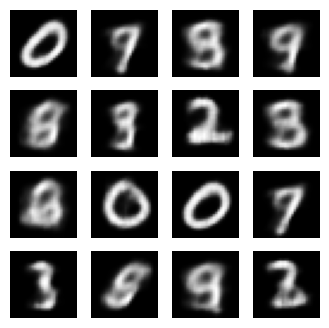

In [13]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### 最後のトレーニングエポックから生成された画像を表示する

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

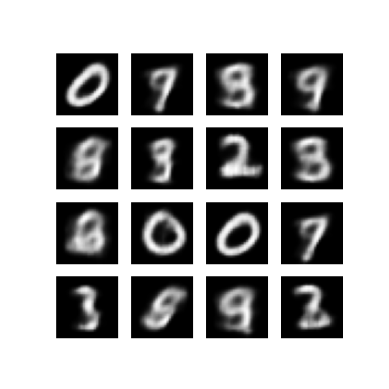

In [15]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### 保存したすべての画像のアニメーション GIF を表示する

In [16]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmpfs/tmp/ipykernel_88741/1290275450.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


/tmpfs/tmp/ipykernel_88741/1290275450.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### 潜在空間から数字の 2D 多様体を表示する

次のコードを実行すると、各数字が 2D 潜在空間で別の数字に変化する、さまざまな数字クラスの連続分布が表示されます。潜在空間の標準正規分布の生成には、[TensorFlow Probability](https://www.tensorflow.org/probability) を使用します。

In [18]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [19]:
plot_latent_images(model, 20)

## 次のステップ

このチュートリアルでは、TensorFlow を使用して畳み込み変分オートエンコーダを実装する方法を実演しました。

次のステップとして、ネットワークサイズを増加し、モデル出力の改善を試みることができます。たとえば、`Conv2D` と `Conv2DTranspose` の各レイヤーの `filter` パラメータを 512 に設定することができます。最終的な 2D 潜在画像プロットを生成するには、`latent_dim` を 2 に維持することが必要であることに注意してください。また、ネットワークサイズが高まると、トレーニング時間も増大します。

また、CIFAR-10 などのほかのデータセットを使って VAE を実装してみるのもよいでしょう。

VAE は、さまざまなスタイルや複雑さの異なるスタイルで実装することができます。その他の実装については、次のリンクをご覧ください。

- [変分オートエンコーダ (keras.io)](https://keras.io/examples/generative/vae/)
- [「カスタムレイヤーとモデルを記述する」ガイドの VAE サンプル（tensorflow.org）](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP 確率レイヤー: 変分オートエンコーダ](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

VAE をさらに詳しく学習するには、「[An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)」をご覧ください。